## Import Libraries

In [110]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

## Download & Load dataset

In [13]:
# Untar is a fastAI function to download data from a URL and return the path of the folder where its downloaded
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path 
#Checking the contents by using FastAI Path library extension
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [215]:
## Getting the file location of files withing 3s and 7s
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

In [28]:
## Lets look at one image
Image.open(threes[1])

In [29]:
Image.open(threes[1]).shape

(28, 28)

In [41]:
## We can see an image as numbers using Pandas functionality
df = pd.DataFrame(array(Image.open(threes[1]))[4:28,4:21])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0


In [216]:
## Loading all data
threeList = [tensor(Image.open(o)) for o in threes]
sevenList = [tensor(Image.open(o)) for o in sevens]

In [217]:
## Printing shape
len(threeList), len(sevenList)

(6131, 6265)

In [218]:
## Converting list of tensors into a tensor matrix
stacked_threes = torch.stack(threeList).float()/255
stacked_sevens = torch.stack(sevenList).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

## Load Train and Testing data

In [219]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)
train_y = torch.stack([tensor(1).float()]*len(threes) + [tensor(0).float()]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [220]:
train_ds = list(zip(train_x, train_y))

In [221]:
stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls().sorted()]).float()/255
stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls().sorted()]).float()/255

In [222]:
valid_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)
valid_y = torch.stack([tensor(1).float()]*stacked_threes.shape[0] + [tensor(0).float()]*stacked_sevens.shape[0]).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [223]:
valid_ds = list(zip(valid_x, valid_y))

## Building simple linear model from scratch

In [224]:
def init_params(size, var=1.0): return (torch.randn(size) * var).requires_grad_()

In [387]:
def linear_model(x): return x@weights.T + bias

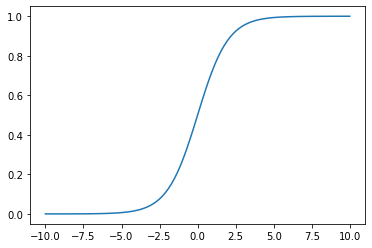

In [226]:
## Calulating loss 
def sigmoid_function(x): return 1/ (1+torch.exp(-x))
plot_function(sigmoid_function, min=-10, max=10)

In [227]:
def categorical_entropy(y, preds):
    predictions = sigmoid_function(preds)
    return torch.where(y == 1, 1-predictions, predictions).mean()

In [389]:
## Initializing weights, bias and learning rate
weights = init_params([1,784])
bias = init_params([1])
lr = 1.

In [392]:
## Running gradient decent (3000 epochs)
for i in range(3001):
    params = [weights, bias]
    ## Getting Predictions
    preds = linear_model(train_x)
    
    ## Calculating loss
    loss = categorical_entropy(train_y, preds)
    loss.backward()
    
    ## Calculating validation accuracy
    preds = sigmoid(linear_model(valid_x)) > 0.5
    accuracy = (valid_y == preds).float().mean()
    if i%200==0:
        print("Epoch:{0}, Loss:{1}, Valid Accuracy:{2}".format(i,loss, accuracy))
    
    ## Updating weights
    for p in params:
        p.data -= p.grad * lr
        p.grad.zero_()

Epoch:0, Loss:0.5009974241256714, Valid Accuracy:0.5147203207015991
Epoch:200, Loss:0.03785894438624382, Valid Accuracy:0.9666339755058289
Epoch:400, Loss:0.03023432567715645, Valid Accuracy:0.9730127453804016
Epoch:600, Loss:0.026194751262664795, Valid Accuracy:0.9749754667282104
Epoch:800, Loss:0.023828089237213135, Valid Accuracy:0.9749754667282104
Epoch:1000, Loss:0.022284384816884995, Valid Accuracy:0.9759567975997925
Epoch:1200, Loss:0.021170921623706818, Valid Accuracy:0.9779195189476013
Epoch:1400, Loss:0.020290326327085495, Valid Accuracy:0.9784101843833923
Epoch:1600, Loss:0.019550185650587082, Valid Accuracy:0.9793915748596191
Epoch:1800, Loss:0.01891574263572693, Valid Accuracy:0.9798822402954102
Epoch:2000, Loss:0.018370214849710464, Valid Accuracy:0.9803729057312012
Epoch:2200, Loss:0.017899947240948677, Valid Accuracy:0.9808635711669922
Epoch:2400, Loss:0.017491847276687622, Valid Accuracy:0.981354296207428
Epoch:2600, Loss:0.017133107408881187, Valid Accuracy:0.98233562

Looks good we are at 98.3% accuracy

## Stochastic Gradient Decent

Stochastic gradient descent is just gradient decent running on minibatches

In [394]:
## Creating mini-batches using Dataloader function
dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256)

In [425]:
def calc_grad(xb, yb, model):
    '''
    Function to run a forward pass on a mini-batch and calculate gradients
    '''
    preds = model(xb)
    loss = categorical_entropy(yb, preds)
    loss.backward()
    
def train_epoch(model, lr, params):
    '''
    Function to run a epoch running multiple mini-batches and updating weights
    '''
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

def batch_accuracy(xb, yb):
    '''
    Function to calculate accuracy given predictions and actuals
    '''
    preds = sigmoid_function(xb)
    correct = ((preds > 0.5).float() == yb)
    return correct.float().mean()

def validate_epoch(model):
    '''
    Function to calculate accuracy of the model on validation data given a model
    '''
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [426]:
## Initializing weights, bias and learning rate for SGD
weights = init_params([1,784])
bias = init_params([1])
lr = 1.
params = weights, bias


In [427]:
# Running SGD for 20 epochs
for epoch in range(20):
    train_epoch(linear_model, lr, params)
    valid_acc = validate_epoch(linear_model)
    print("Epoch:{0} , Validation Acc:{1:.2f}%".format(epoch, valid_acc*100))

Epoch:0 , Validation Acc:92.81%
Epoch:1 , Validation Acc:94.82%
Epoch:2 , Validation Acc:95.06%
Epoch:3 , Validation Acc:95.35%
Epoch:4 , Validation Acc:95.60%
Epoch:5 , Validation Acc:95.79%
Epoch:6 , Validation Acc:96.04%
Epoch:7 , Validation Acc:96.14%
Epoch:8 , Validation Acc:96.33%
Epoch:9 , Validation Acc:96.48%
Epoch:10 , Validation Acc:96.53%
Epoch:11 , Validation Acc:96.67%
Epoch:12 , Validation Acc:96.87%
Epoch:13 , Validation Acc:96.97%
Epoch:14 , Validation Acc:97.02%
Epoch:15 , Validation Acc:97.16%
Epoch:16 , Validation Acc:97.16%
Epoch:17 , Validation Acc:97.26%
Epoch:18 , Validation Acc:97.31%
Epoch:19 , Validation Acc:97.36%


Looks good, we are at 97.36% accuracy

## Creating an optimizer

In [452]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *agrs, **kwargs):
        for p in self.params: p.grad.zero_()

In [ ]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
def train_model(model, epoch):
    for e in range(epoch):
        train_epoch(linear_model)
        valid_acc = validate_epoch(linear_model)
        print("Epoch:{0} , Validation Acc:{1:.2f}%".format(e, valid_acc*100))

In [461]:
linear_model = nn.Linear(28*28, 1)
## Initializing optimizer
opt = BasicOptim(linear_model.parameters(), lr =1.)

In [462]:
## Train for 20 epochs
train_model(linear_model, 20)

Epoch:0 , Validation Acc:97.06%
Epoch:1 , Validation Acc:97.50%
Epoch:2 , Validation Acc:97.65%
Epoch:3 , Validation Acc:97.70%
Epoch:4 , Validation Acc:97.80%
Epoch:5 , Validation Acc:97.95%
Epoch:6 , Validation Acc:97.85%
Epoch:7 , Validation Acc:97.99%
Epoch:8 , Validation Acc:97.95%
Epoch:9 , Validation Acc:98.04%
Epoch:10 , Validation Acc:98.04%
Epoch:11 , Validation Acc:98.19%
Epoch:12 , Validation Acc:98.09%
Epoch:13 , Validation Acc:98.19%
Epoch:14 , Validation Acc:98.24%
Epoch:15 , Validation Acc:98.24%
Epoch:16 , Validation Acc:98.19%
Epoch:17 , Validation Acc:98.24%
Epoch:18 , Validation Acc:98.34%
Epoch:19 , Validation Acc:98.19%


## Using Pytorch SGD Function

In [466]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)

In [467]:
train_model(linear_model, 20)

Epoch:0 , Validation Acc:97.01%
Epoch:1 , Validation Acc:97.60%
Epoch:2 , Validation Acc:97.55%
Epoch:3 , Validation Acc:97.60%
Epoch:4 , Validation Acc:97.75%
Epoch:5 , Validation Acc:97.90%
Epoch:6 , Validation Acc:97.90%
Epoch:7 , Validation Acc:97.95%
Epoch:8 , Validation Acc:97.95%
Epoch:9 , Validation Acc:97.99%
Epoch:10 , Validation Acc:97.99%
Epoch:11 , Validation Acc:97.99%
Epoch:12 , Validation Acc:98.14%
Epoch:13 , Validation Acc:98.14%
Epoch:14 , Validation Acc:98.24%
Epoch:15 , Validation Acc:98.09%
Epoch:16 , Validation Acc:98.19%
Epoch:17 , Validation Acc:98.19%
Epoch:18 , Validation Acc:98.34%
Epoch:19 , Validation Acc:98.19%


Same results!

## Using FastAI function

In [474]:
dls = DataLoaders(dl, valid_dl)

In [491]:
## Need to rewrite functions as the learner takes functions with prediction, target as ip
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def batch_accuracy(xb, yb):
    '''
    Function to calculate accuracy given predictions and actuals
    '''
    preds = sigmoid_function(xb)
    correct = ((preds > 0.5).float() == yb)
    return correct.float().mean()

In [489]:
learn = Learner(dls = dls, model = nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [490]:
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.059424,0.041718,0.971050,00:00
1,0.040676,0.034971,0.974485,00:00
2,0.032632,0.031852,0.975957,00:00
3,0.028465,0.029870,0.976938,00:00
4,0.025528,0.028511,0.978410,00:00
5,0.023832,0.027159,0.979392,00:00
6,0.022329,0.026490,0.979882,00:00
7,0.021117,0.025315,0.979882,00:00
8,0.020728,0.024980,0.980864,00:00
9,0.019760,0.024311,0.980864,00:00


## Adding Non-Linearity

In [493]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [494]:
learn = Learner(dls = dls, model = simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [495]:
learn.fit(40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.228883,0.091596,0.966143,00:00
1,0.108922,0.054122,0.969087,00:00
2,0.067151,0.044367,0.970559,00:00
3,0.048629,0.039715,0.970069,00:00
4,0.039262,0.036837,0.971541,00:00
5,0.033895,0.034612,0.973013,00:00
6,0.030768,0.033057,0.973994,00:00
7,0.028214,0.031839,0.975957,00:00
8,0.026328,0.030619,0.976448,00:00
9,0.024962,0.030005,0.974975,00:00


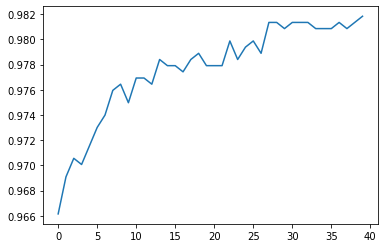

In [499]:
plt.plot(L(learn.recorder.values).itemgot(2))

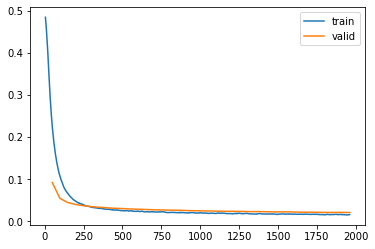

In [500]:
learn.recorder.plot_loss()